# NYC taxi trips on Thanksgiving 2018 analysis

In this project we will be analyzing a dataset containing information regarding NY taxi trips on Thanksgiving 2018.

The scope of the project includes several steps:
1. **Explore and clean the data:** As in any other project, there is a fundamental first phase that needs to be implemented in order to validate the completeness and the correctness of data. First, the nature of the data will be explored, to know the nº of samples, nº of variables and how data is distributed. Besides, data will be cleaned to ease more advanced analytics that will follow in the next stages.
<br><br>
2. **Data summary and relevant trends:** The NY city council is very interested on understanding taxi trips on thanksgiving. We will attempt to discover relevant insights that may be very impactful for public politics. Therefore, we will look for trends on data and present them on such a way that workers at the NY city council can easily interpret them. This stage will involve exploring relations among variables that may lead to insightful findings. On top of that, visualizations will be very useful to understand relations and to bring to light hidden patterns on data.
<br><br>
3. **Model building:** Finally, the NY city council is interested on the typical tip clients give to taxi drivers and what factors influence the tip the most. In order to do so, we will be focusing our analysis on the tips building several machine learning models that may help us and the city council to understand how tips behave.

## Libraries and configuration

First we begin importing useful libraries for data management, visualization and building models.

In [1]:
import pandas as pd
import numpy as np
import shapefile as shp
import geopandas

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import contextily as cx
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

Configure colors and visualitation style.

In [2]:
sns.set_style("whitegrid", {'axes.grid' : False})
color_palette = ['#ffa600', '#ff766e', "#e770af", "#937ec3", "#517ea6"]
three_color = ["#ff766e", "#517ea6", "#ffa600", "#937ec3", "#e770af"]
color = "#ff766e"


sns.set(font='Franklin Gothic Book',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': '#fafcfb',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

## 1. Data exploration and cleaning

### Data importation

First, we proceed to import data in *.csv* format and save it into a pandas dataframe.

In [3]:
df = pd.read_csv('ny_thanksgiving_2018.csv')

### Basic data exploration

Now we proceed to perform basic data exploration. Let's first visualize how the first samples look like.

It seems like each row represents a single taxi trip. It contains several variables each of them describing different category of the trip.

In [4]:
df.head()

vendor_id      pickup_datetime     dropoff_datetime  passenger_count  \
0          2  2018-11-22 18:28:51  2018-11-22 18:33:10                1   
1          2  2018-11-22 02:00:35  2018-11-22 02:00:39                1   
2          2  2018-11-22 13:54:37  2018-11-22 13:54:42                1   
3          2  2018-11-22 01:38:35  2018-11-22 01:40:48                1   
4          1  2018-11-22 19:07:20  2018-11-22 19:07:20                0   

   trip_distance  rate_code store_and_fwd_flag  payment_type  fare_amount  \
0            0.0          1                  N             1          0.0   
1            0.0          1                  N             2          0.0   
2            0.0          1                  N             1          0.0   
3            0.0          1                  N             1          0.0   
4            0.0          5                  N             2          0.0   

   extra  mta_tax  tip_amount  tolls_amount  imp_surcharge  total_amount  \
0    0.0      0.0         0.0           0.0            0.0           0.0   
1    0.0      0.0         0.0           0.0            0.0           0.0   
2    0.0      0.0         0.0           0.0            0.0           0.0   
3    0.0      0.0         0.0           0.0            0.0           0.0   
4    0.0      0.0         0.0           0.0            0.0           0.0   

   pickup_location_id  dropoff_location_id  
0                 193                  193  
1                 264                  264  
2                 264                  152  
3                 193                  193  
4                 158                  264

But...how many taxi trips the dataset contains? And how many variables?

In [5]:
print(df.shape)

(174347, 17)


In [6]:
n_rows = df.shape[0]
n_columns = df.shape[1]
print("The dataset contains information about " + str(n_rows) + " taxi trips.")
print("The information of each taxi trip is stored in " + str(n_columns) + " different varaibles.")

The dataset contains information about 174347 taxi trips.
The information of each taxi trip is stored in 17 different varaibles.


Before proceeding with further analysis it is essential to know the kind of variables the dataset contains. Let's begin by retrieving all the names of the variables and its types.

We have 14 numerical variables and 3 object variables. ***pickup_datetime*** and ***dropoff_datetime*** are of type string but maybe it is worth to convert them to datetime so it is easier to operate when needed. We will do it later on.

In [7]:
df.dtypes

vendor_id                int64
pickup_datetime         object
dropoff_datetime        object
passenger_count          int64
trip_distance          float64
rate_code                int64
store_and_fwd_flag      object
payment_type             int64
fare_amount            float64
extra                  float64
mta_tax                float64
tip_amount             float64
tolls_amount           float64
imp_surcharge          float64
total_amount           float64
pickup_location_id       int64
dropoff_location_id      int64
dtype: object

### Feature creation and transformation

In this subsection we will perform feature engineering in orther to create new features from the ones we already have.

Convert time variables into date-time types.

In [8]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])

Now from these variables we can obtain ***trip_duration*** in seconds.

In [9]:
df["trip_duration"] = df["dropoff_datetime"] - df["pickup_datetime"]
df["trip_duration"] = df["trip_duration"].map(lambda x: x.total_seconds())

Check that **trip_duration** has been created correctly.

In [10]:
df[["pickup_datetime", "dropoff_datetime", "trip_duration"]][:2]

pickup_datetime    dropoff_datetime  trip_duration
0 2018-11-22 18:28:51 2018-11-22 18:33:10          259.0
1 2018-11-22 02:00:35 2018-11-22 02:00:39            4.0

Now, with the ***trip_distance*** and the ***trip_duration*** we can obtain the average ***trip_speed***. Let's calculate it in Km/h as we are more familiar with this unit (divide distance by time, then convert milles to km and seconds to hours). We will also convert **trip_distance** to Km instead of milles.

Prior to calculate the ***trip_speed*** lets drop rows that have either 0 duration or 0 distance to avoid inconsistent results such as 0 speed or infinite speed.

In [11]:
df = df[(df["trip_distance"] != 0)]
df = df[(df["trip_duration"] != 0)]

Now we can calculate ***trip_speed***

In [12]:
df["trip_distance"] = df["trip_distance"] * 1.60934
df["trip_speed"] = df["trip_distance"] / df["trip_duration"]
df["trip_speed"] = df["trip_speed"] * (3600) # Convert milles to km (1 mille = 1.609 Km) and seconds to hours (1 h =3600 s)

Let's check results make sense. Apparently the ***trip_speed*** has been calculated correctly.

In [13]:
df[["trip_speed", "trip_distance", "trip_duration"]].tail(3)

trip_speed  trip_distance  trip_duration
174344   24.976665      18.378663         2649.0
174345   47.576407      13.598923         1029.0
174346   20.210316       0.482802           86.0

We can also create other new features from time variables:
* ***pickup_hour*** and ***dropoff_hour***: Two new features displaying the hour of the pick-up and dropp-off.
* ***pickup_day_time*** and ***dropoff_day_time***: Two new categorical features that encode the hour into more human readable features (morning, afternoon, evening, night and late night)

In [14]:
df["pickup_hour"] = df["pickup_datetime"].dt.hour
df["dropoff_hour"] = df["dropoff_datetime"].dt.hour

Create a function to encode hours into time of the day categories:

In [15]:
def day_time(hour):
    if hour in range(6, 12):
        return "Morning"
    elif hour in range(12, 16):
        return "Afternoon"
    elif hour in range(16, 21):
        return "Evening"
    elif hour in range(21, 24):
        return "Night"
    else:
        return "Late Night"

Create the new variables.

In [16]:
df["pickup_day_time"] = df["pickup_hour"].map(day_time)
df["dropoff_day_time"] = df["dropoff_hour"].map(day_time)

Let's check that the new ***day_time*** categories look correct.

In [17]:
df[["pickup_hour", "pickup_day_time"]][-4:]

pickup_hour pickup_day_time
174343           22           Night
174344           13       Afternoon
174345           10         Morning
174346            2      Late Night

### Dealing with nulls and outliers

#### Nulls

One of the first things to check in this type of analysis is data completeness. We will be checking how many Nulls we find per variable.

We have been very lucky, there is not a single Null for any of the features!!!

In [23]:
df.isna().sum()

vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
trip_distance          0
rate_code              0
store_and_fwd_flag     0
payment_type           0
fare_amount            0
extra                  0
mta_tax                0
tip_amount             0
tolls_amount           0
imp_surcharge          0
total_amount           0
pickup_location_id     0
dropoff_location_id    0
trip_duration          0
trip_speed             0
pickup_hour            0
dropoff_hour           0
pickup_day_time        0
dropoff_day_time       0
dtype: int64

#### Outliers

Now we can visualise basic statistics of the dataset variables.

There are some variables that are categorical as indicated in https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf, such as ***vendor_id***, ***rate_code***, ***pickup_location_id*** or ***dropoff_location_id***.

Regarding the numerical variables it is worth highlighting the ones that have to do with costs of the trip: ***fare_amount***, ***extra***, ***mta_tax***, ***tip_amount***, ***tolls_amount***, ***imp_surcharge*** and ***total_amount***. All of these variables include minimum values that are negative. If these negative values do not make sense we will drop the associated taxi trips.

In [24]:
df.describe()

vendor_id  passenger_count  trip_distance      rate_code  \
count  172969.000000    172969.000000  172969.000000  172969.000000   
mean        1.678272         1.660702       4.894400       1.047425   
std         0.577997         1.261571       6.300609       0.402343   
min         1.000000         0.000000       0.016093       1.000000   
25%         1.000000         1.000000       1.561060       1.000000   
50%         2.000000         1.000000       2.735878       1.000000   
75%         2.000000         2.000000       5.198168       1.000000   
max         4.000000         8.000000     163.026142      99.000000   

        payment_type    fare_amount          extra        mta_tax  \
count  172969.000000  172969.000000  172969.000000  172969.000000   
mean        1.423533      13.171287       0.179828       0.497034   
std         0.513614     450.799021       0.269413       0.044204   
min         1.000000    -200.000000      -4.500000      -0.500000   
25%         1.000000       6.000000       0.000000       0.500000   
50%         1.000000       8.500000       0.000000       0.500000   
75%         2.000000      13.500000       0.500000       0.500000   
max         4.000000  187436.460000      18.000000       0.500000   

          tip_amount   tolls_amount  imp_surcharge   total_amount  \
count  172969.000000  172969.000000  172969.000000  172969.000000   
mean        1.448600       0.295242       0.299400      15.898855   
std         2.391418       1.448527       0.018856     450.858445   
min       -11.000000     -10.000000      -0.300000    -200.300000   
25%         0.000000       0.000000       0.300000       7.550000   
50%         1.000000       0.000000       0.300000      10.380000   
75%         2.000000       0.000000       0.300000      16.000000   
max       150.000000      44.000000       0.300000  187437.760000   

       pickup_location_id  dropoff_location_id  trip_duration     trip_speed  \
count       172969.000000        172969.000000  172969.000000  172969.000000   
mean           162.822789           159.002949     948.067197      24.327385   
std             68.368668            72.468971    4704.482780     110.488284   
min              1.000000             1.000000       1.000000       0.004023   
25%            113.000000           100.000000     312.000000      15.866356   
50%            161.000000           162.000000     525.000000      20.318484   
75%            233.000000           233.000000     885.000000      26.637352   
max            265.000000           265.000000   86398.000000   22015.771200   

         pickup_hour   dropoff_hour  
count  172969.000000  172969.000000  
mean       13.458839      13.506669  
std         6.353704       6.400172  
min         0.000000       0.000000  
25%        10.000000      10.000000  
50%        14.000000      14.000000  
75%        19.000000      19.000000  
max        23.000000      23.000000

At this point we figured out that is useful to cisualize the distribution of the features to discover outliers.

The distributions reveal some outliers. As observed, there are some negative values for ***fare_amount***, ***tolls_amount***, ***tip_amount*** and ***total_amount***. Since we have a dataset with a large number of samples, we can afford to drop outliers with the purpose of not spoiling the analysis and modelling phases.

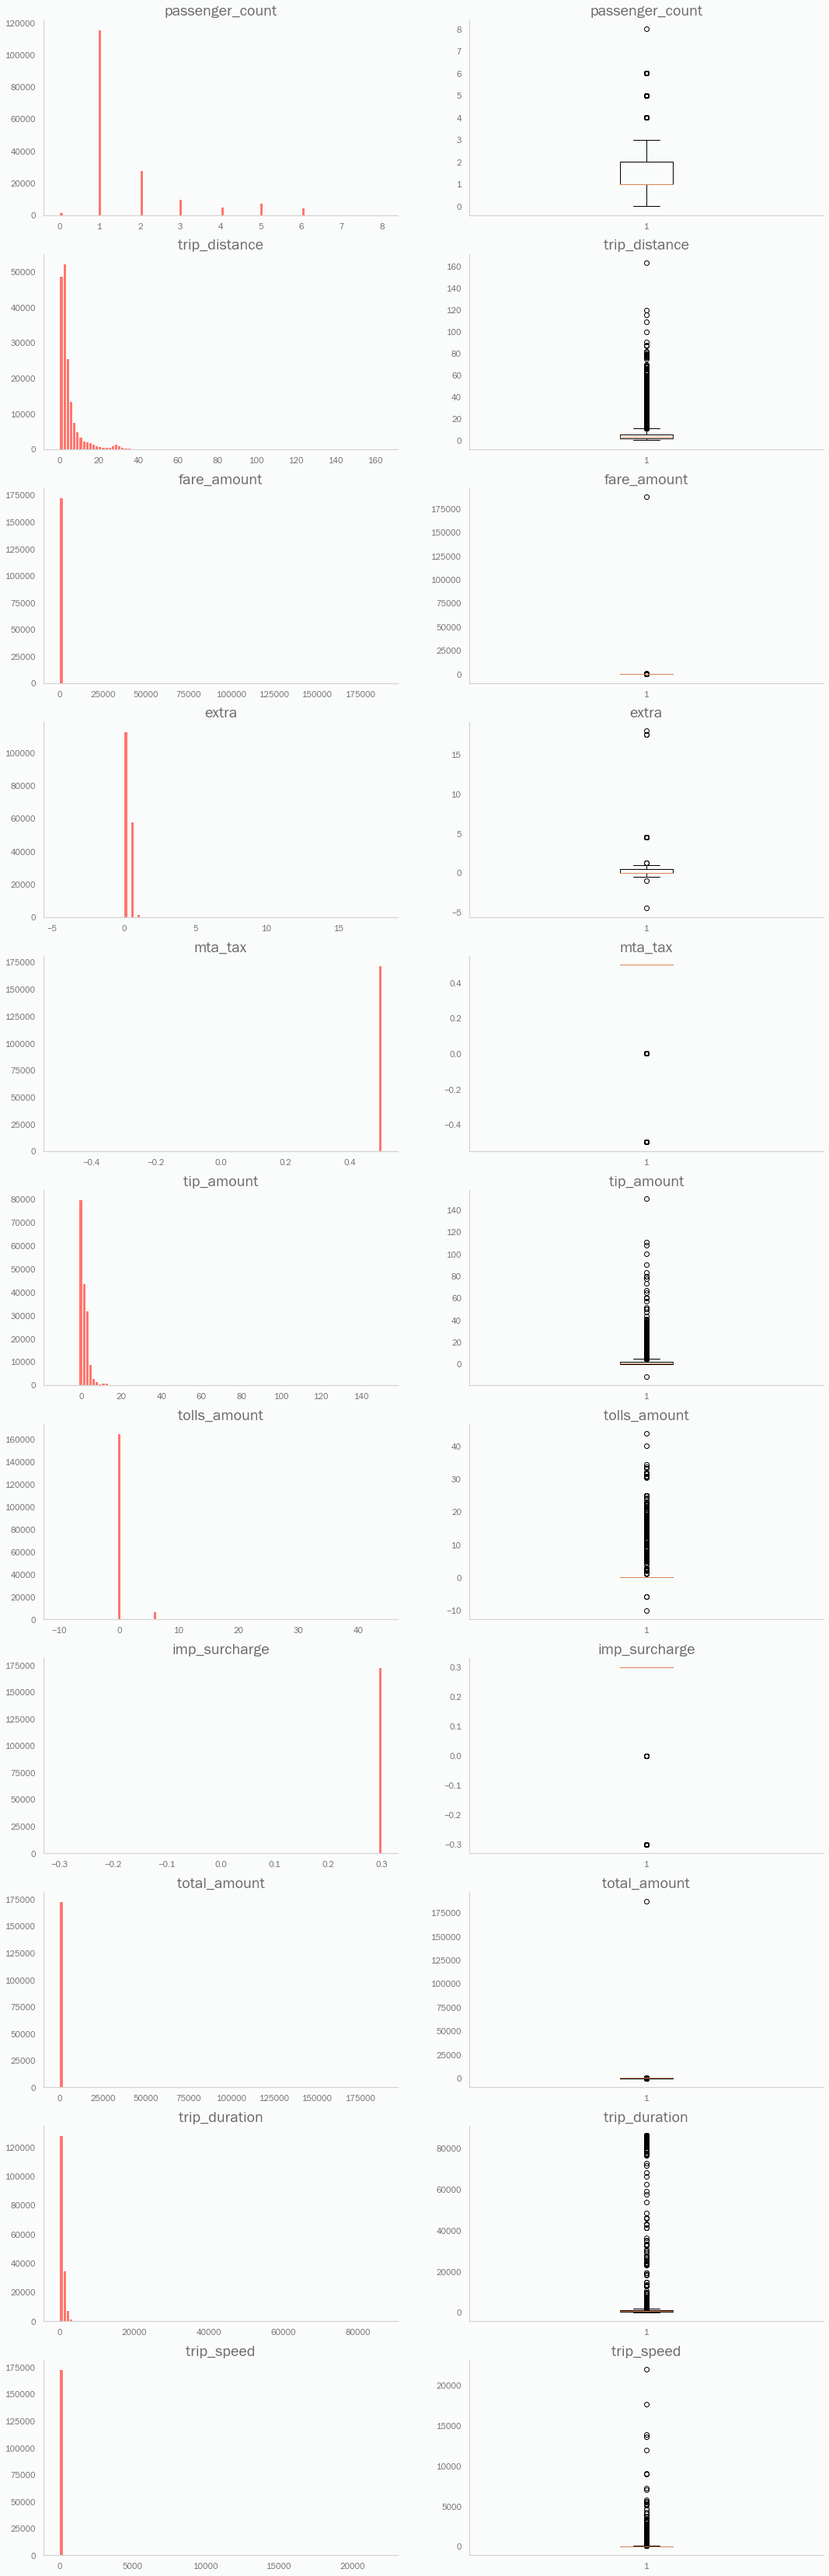

In [25]:
numerical_columns = ["passenger_count", "trip_distance", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "imp_surcharge", "total_amount", "trip_duration", "trip_speed"]

fig, axs = plt.subplots(len(numerical_columns), 2, figsize=(18,60))
for i, column in enumerate(numerical_columns):
    axs[i, 0].hist(df[column], bins=100, color = color)
    axs[i, 0].set_title(column)
    
    axs[i, 1].boxplot(df[column])
    axs[i, 1].set_title(column)

Let's drop trips with a number of passengers equal to 0 as it is pretty strange and it might be an anotation failure. We also found that there is a single trip with 8 passengers and we will drop it.

In [26]:
df = df[df["passenger_count"] != 0]
df = df[df["passenger_count"] != 8]

Let's drop the samples with ***fare_amount*** over 100000.
We will also drop the samples with negative ***fare_amount***, altough we don't know the reason (it could mean a refund) it is not worth taking the risk and just drop these samples.

In [27]:
df = df[df["fare_amount"] < 100000]
df = df[df["fare_amount"] > 0]

Besides, there are trips that have a ridiculous ***trip_duration*** over 8 hours (8hours == 28800s) and more. We will drop them since probably the pick-up and drop-off time were incorrect.

In [28]:
df = df[df["trip_duration"] < 28800]

Moreover, it doesn't make sense trips with an average ***trip_speed*** over 152 Km/h given that they are trips within a city and there are not highways. Since they do not represent a lot of samples we can just drop them to support consistency between distance and duration.

In [29]:
df = df[df["trip_speed"] < 152]

There are also outliers for ***mta_tax*** and the ***imp_surcharge*** that should always have the same values, 0.5 and 0.3 respectively. However, in this case we will not drop the samples as they just have 0 for these two variables and the rest of the variables appear to be consistent.

Now the distributions make much more sense:

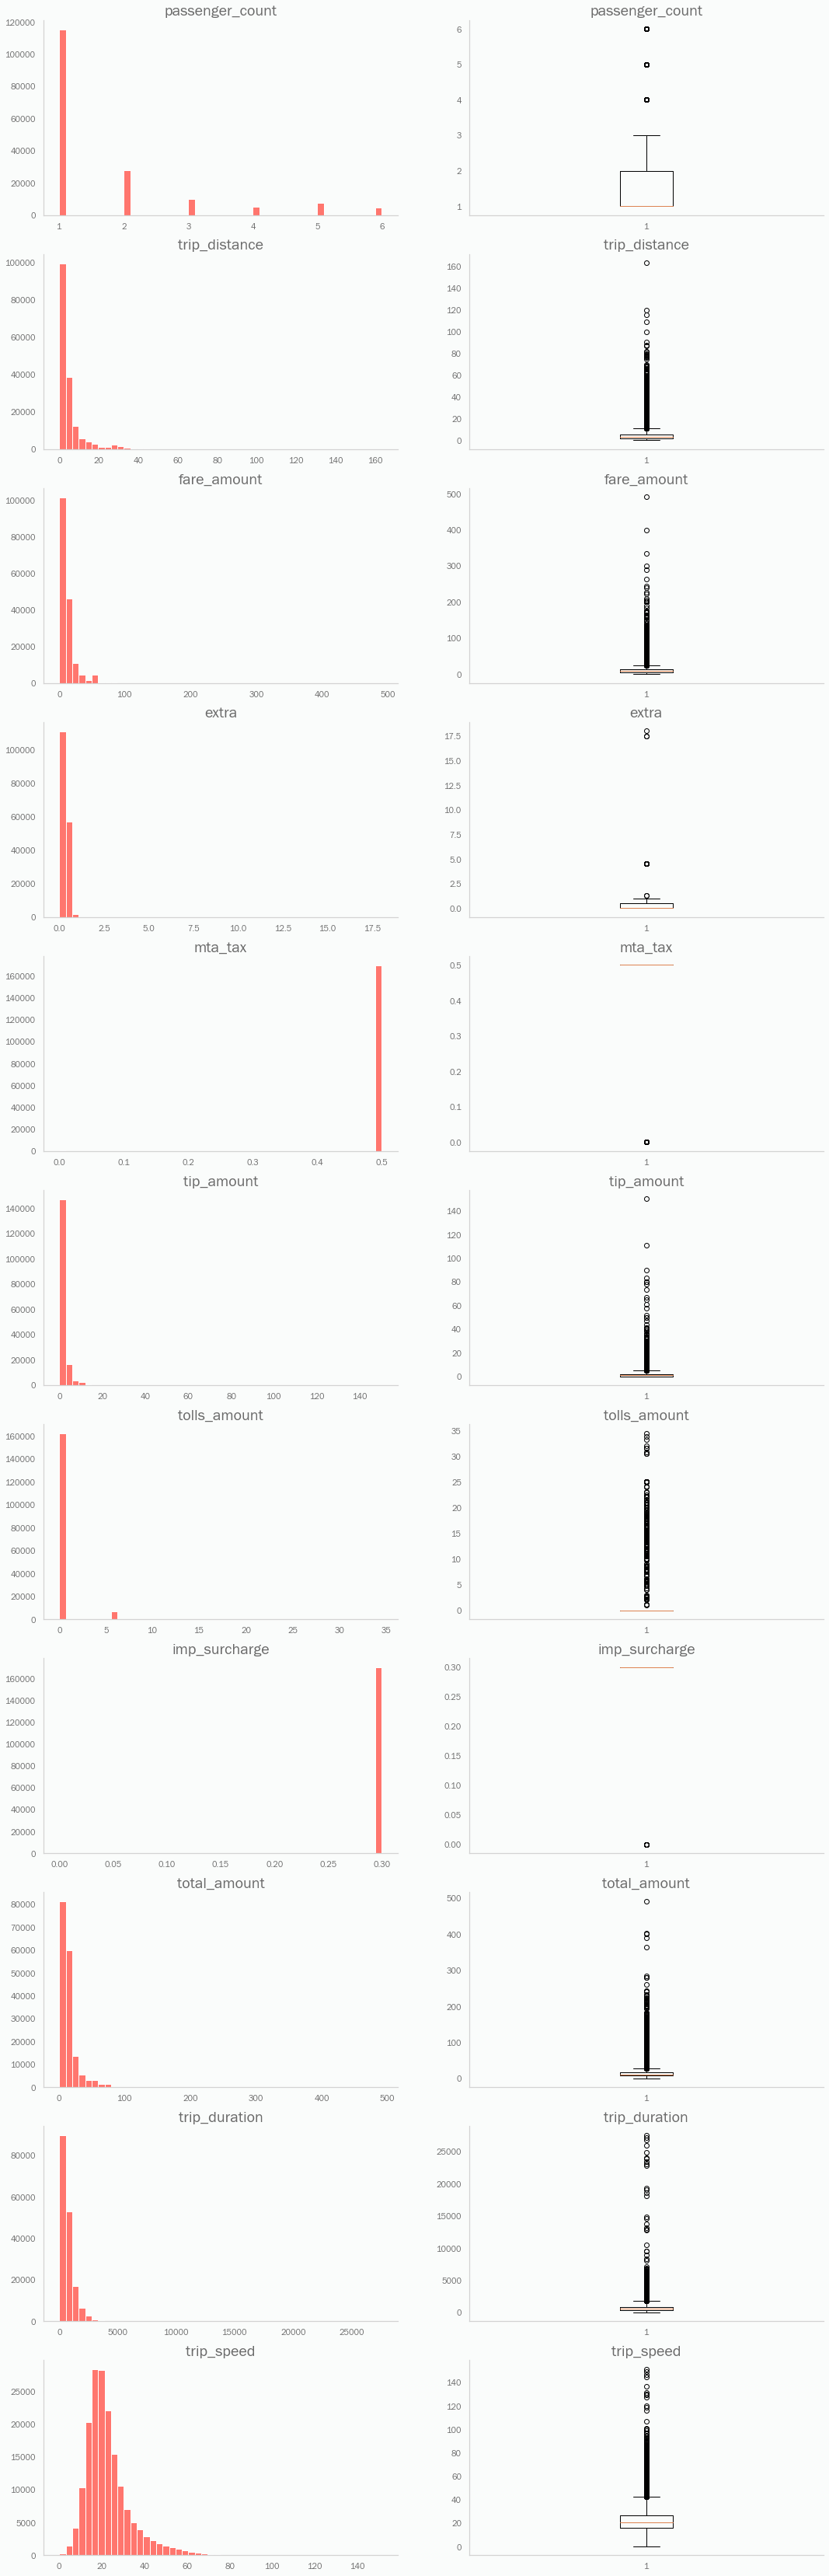

In [30]:
numerical_columns = ["passenger_count", "trip_distance", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "imp_surcharge", "total_amount", "trip_duration", "trip_speed"]

fig, axs = plt.subplots(len(numerical_columns), 2, figsize=(18,60))
for i, column in enumerate(numerical_columns):
    axs[i, 0].hist(df[column], bins=50, color=color)
    axs[i, 0].set_title(column)
    
    axs[i, 1].boxplot(df[column])
    axs[i, 1].set_title(column)

Let's take a look if there is wrong data in ***rate_code***.

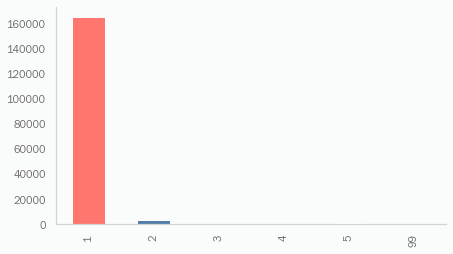

In [31]:
df["rate_code"].value_counts().sort_index().plot.bar(x='rate_code', y='Number of Occurrences', colors=three_color, figsize=(7,4))
plt.show()

We have few samples with ***rate_code = 99*** but this value was not indicated in the dataset information so we will drop them.

In [32]:
df = df[df["rate_code"] != 99]

The distribution of ***store_and_fwd_flag*** is quite unbalanced, but we will leave it like that.

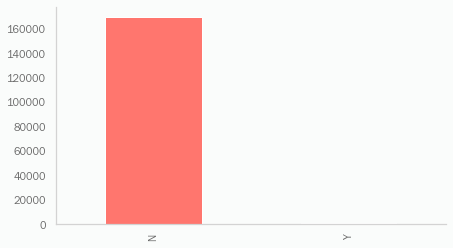

In [35]:
df["store_and_fwd_flag"].value_counts().sort_index().plot.bar(x='store_and_fwd_flag', y='Number of Occurrences', color=three_color, figsize=(7,4))
plt.show()

We have two dominating ***vendor_id***, vendor 1 and vendor 2. There is a third vendor with not much representation but it doesn't represent any problem for the analysis .

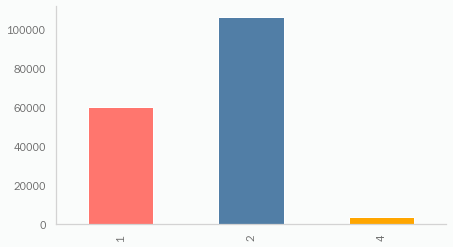

In [36]:
df["vendor_id"].value_counts().sort_index().plot.bar(x='vendor_id', y='Number of Occurrences', color=three_color, figsize=(7,4))
plt.show()

We have credit card (1) and cash (2) payments dominating for ***payment_type*** without any outliers.

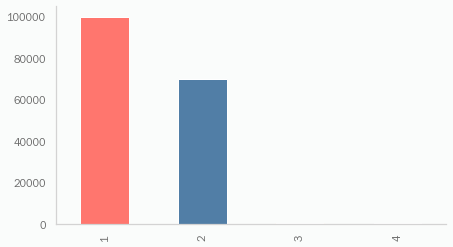

In [37]:
df["payment_type"].value_counts().sort_index().plot.bar(x='payment_type', y='Number of Occurrences', color=three_color, figsize=(7,4))
plt.show()

Let's reset the index of the dataframe now that we have finished cleaning data.

In [38]:
df = df.reset_index(drop=True)

The final statistics of the variables look like that.

In [39]:
df.describe()

vendor_id  passenger_count  trip_distance      rate_code  \
count  170194.000000    170194.000000  170194.000000  170194.000000   
mean        1.685018         1.678731       4.890309       1.045184   
std         0.577510         1.255542       6.293081       0.317241   
min         1.000000         1.000000       0.016093       1.000000   
25%         1.000000         1.000000       1.561060       1.000000   
50%         2.000000         1.000000       2.735878       1.000000   
75%         2.000000         2.000000       5.198168       1.000000   
max         4.000000         6.000000     163.026142       5.000000   

        payment_type    fare_amount          extra        mta_tax  \
count  170194.000000  170194.000000  170194.000000  170194.000000   
mean        1.420397      12.085874       0.180489       0.498228   
std         0.508955      11.381610       0.269357       0.029709   
min         1.000000       0.010000       0.000000       0.000000   
25%         1.000000       6.000000       0.000000       0.500000   
50%         1.000000       8.500000       0.000000       0.500000   
75%         2.000000      13.500000       0.500000       0.500000   
max         4.000000     491.000000      18.000000       0.500000   

          tip_amount   tolls_amount  imp_surcharge   total_amount  \
count  170194.000000  170194.000000  170194.000000  170194.000000   
mean        1.448652       0.294055       0.299986      14.814869   
std         2.354134       1.437351       0.002057      13.613608   
min         0.000000       0.000000       0.000000       0.310000   
25%         0.000000       0.000000       0.300000       7.560000   
50%         1.000000       0.000000       0.300000      10.380000   
75%         2.000000       0.000000       0.300000      16.000000   
max       150.000000      34.520000       0.300000     491.800000   

       pickup_location_id  dropoff_location_id  trip_duration     trip_speed  \
count       170194.000000        170194.000000  170194.000000  170194.000000   
mean           162.773094           158.957866     686.944593      22.750008   
std             68.369443            72.458772     592.533093      10.779970   
min              1.000000             1.000000       2.000000       0.076635   
25%            113.000000           100.000000     313.000000      15.910848   
50%            161.000000           162.000000     525.000000      20.346353   
75%            233.000000           233.000000     881.000000      26.656110   
max            265.000000           265.000000   27551.000000     151.391180   

         pickup_hour   dropoff_hour  
count  170194.000000  170194.000000  
mean       13.458113      13.506645  
std         6.354973       6.400412  
min         0.000000       0.000000  
25%        10.000000      10.000000  
50%        14.000000      14.000000  
75%        19.000000      19.000000  
max        23.000000      23.000000

## 2. Data summary

In this section the goal is to help the NY city council by finding trends and hidden patterns on data. This task will involve different visualitations such as maps, bar-charts, scatter plots or correlations matrix.

### Hour and time of day

One of the most relevant matters to focus at when monitoring taxi trips is the time of the day.

Let's look first how taxi trips are distributed with respect to time. Since most of trips are quite short with a mean duration of 686 seconds (~11 min) we can take either pick-up times or drop-off time, it won't affect much the analysis.

We can observe that the period of less taxi trips activity is between 1 and 8. From 8 onwards there is a quick increase on trips activity until 12, where more or less the peak of activity is found. There is a constant high activity of taxi activity until 16 when the activity is slightly reduced. During 20 and 21 there is again high activity to later decrease from 22.

With respect to times of the day the times with greater activity, are afternoon and evening. On the other side, the day times with least activity are Night and Late Night.

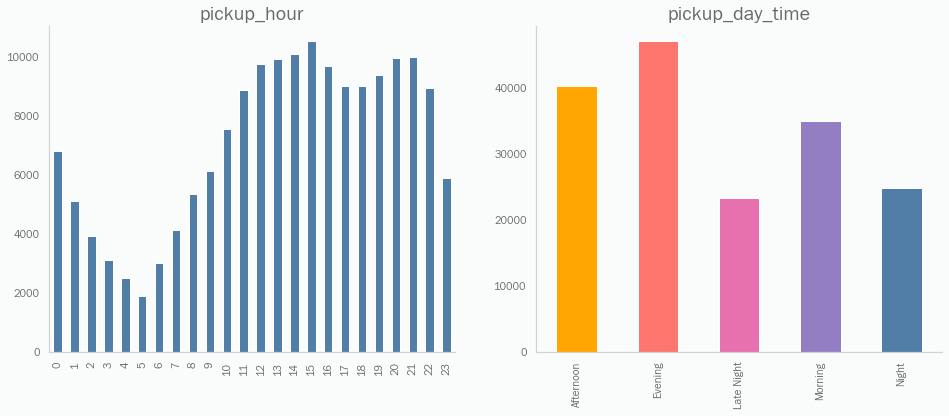

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

ax1 = df["pickup_hour"].value_counts().sort_index().plot.bar(x='pickup_hour', y='Number of Occurrences', ax =axes[0], color=color_palette[4])
ax2 = df["pickup_day_time"].value_counts().sort_index().plot.bar(x='pickup_day_time', y='Number of Occurrences', ax =axes[1], color=color_palette)

ax1.set_title("pickup_hour")
ax2.set_title("pickup_day_time")

plt.show()

### Number of passengers

As we observed before, there is also some variability when it comes to the number of passengers. By studying the distribution of passengers, the NY city council will be able to know if there is high demand for a high amount of people or for less people in the case that most trips are just riding a single passenger.

As it can be observed in the chart below most of Taxi trips involve riding a single passenger. There are also some trips for two passengers, in contrast trips for 3 or more passengers are very rare.

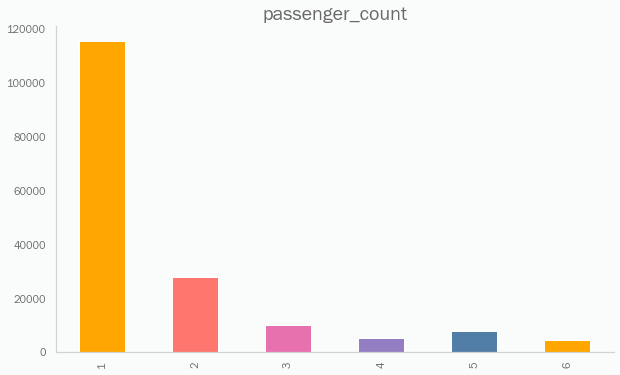

In [41]:
df["passenger_count"].value_counts().sort_index().plot.bar(x='passenger_count', y='Number of Occurrences', color=color_palette, title='passenger_count', figsize=(10, 6))
plt.show()

### Distance, trip duration and speed

**Distance**

Are taxi trips riding people from very long ditances? Otherwise, are they just riding people within the same district involving shorter distances?

In the Figures below we can see both the distribution of the trip distance and the same distribution in a logarithmic scale.

It is easy to see that we have an exponential distribution. Most trips are between 0 and 20 milles and the mean is 3 milles. From 20 milles onwards the number of taxi trips starts decreasing. This make sense since we are analysing trips within NY city where distances altough long for a city are not as long compared to road trips.There are few trips over 40 milles.

With all these insights we can determine that most of trips are involving short distances although there are some very long trips compared to the rest.

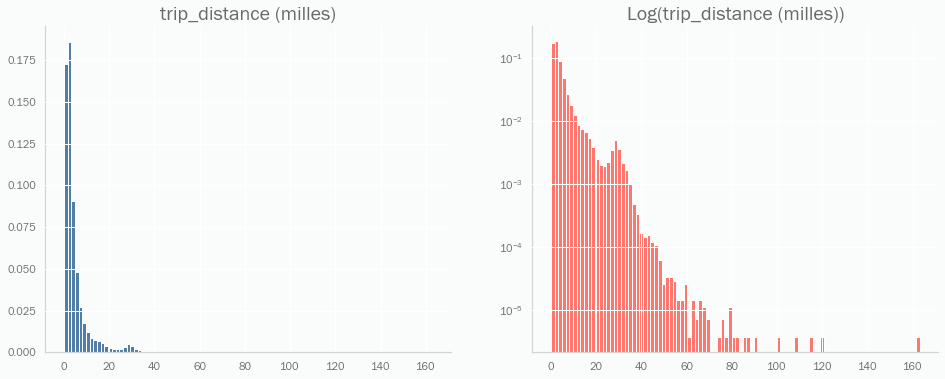

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

ax1 = df["trip_distance"].hist(bins=100, ax =axes[0], density = True, color = color_palette[4])
ax2 = df["trip_distance"].hist(bins=100, ax =axes[1], density = True, color = color_palette[1], log=True)

ax1.set_title("trip_distance (milles)")
ax2.set_title("Log(trip_distance (milles))")

plt.show()

**Trip duration**

Let's now analyse the trip duration in minutes. Since we are used to analyse timelapses in minutes we will convert seconds to minutes.

Similarly to distance, the duration follows an exponential distribution. Most trips are under an hour and the mean is about 13 min. It is very likely that both these variables are very correlated as we will analyse later.

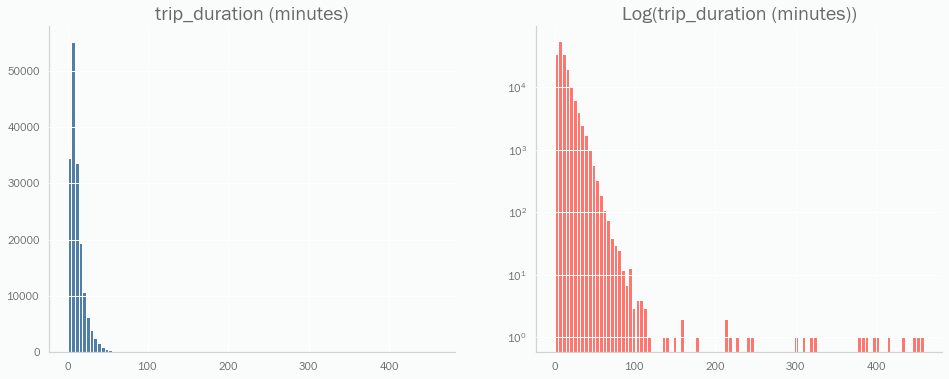

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

ax1 = (df["trip_duration"] / 60).hist(bins=100, ax =axes[0], color = color_palette[4])
ax2 = (df["trip_duration"] / 60).hist(bins=100, ax =axes[1], color = color_palette[1], log=True)

ax1.set_title("trip_duration (minutes)")
ax2.set_title("Log(trip_duration (minutes))")

plt.show()

**Trip speed**

How fast are moving taxis on average on NY city?

In this case we have what it looks like a right-skewed normal distribution with a mean of 22 km/h. It may seem that 22 km/h is slow speed even for a city, however, the cause of this mean speed might be due to heavy traffic jams in New York, traffics lights and many other elements.

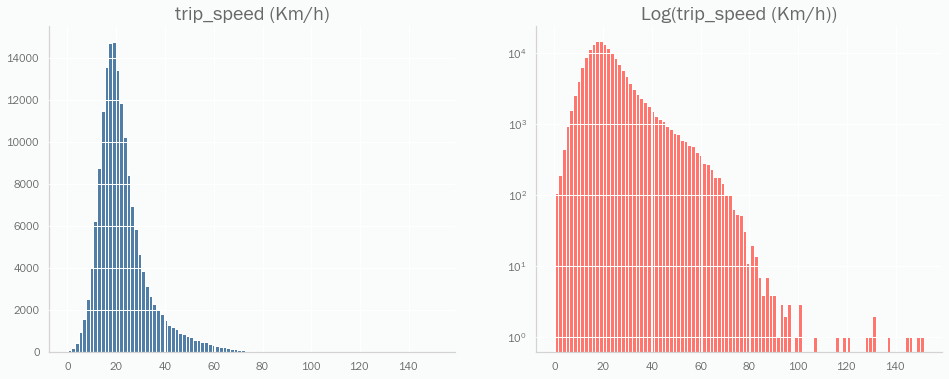

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

ax1 = (df["trip_speed"]).hist(bins=100, ax =axes[0], color = color_palette[4])
ax2 = (df["trip_speed"]).hist(bins=100, ax =axes[1], color = color_palette[1], log=True)

ax1.set_title("trip_speed (Km/h)")
ax2.set_title("Log(trip_speed (Km/h))")

plt.show()

### Total amount and tips

In this case we are interested on analysing the total amount of money paid for each trip and the money given as a tip to drivers.

It is very likely that the **total_fare** is very correlated to the distance and the trip duration, but what about tips? How are they distributed?

**Total amount**

As it was expected we found an exponential distribution, very similar to the distance and duration distributions. These variables might be stronlgy correlated.

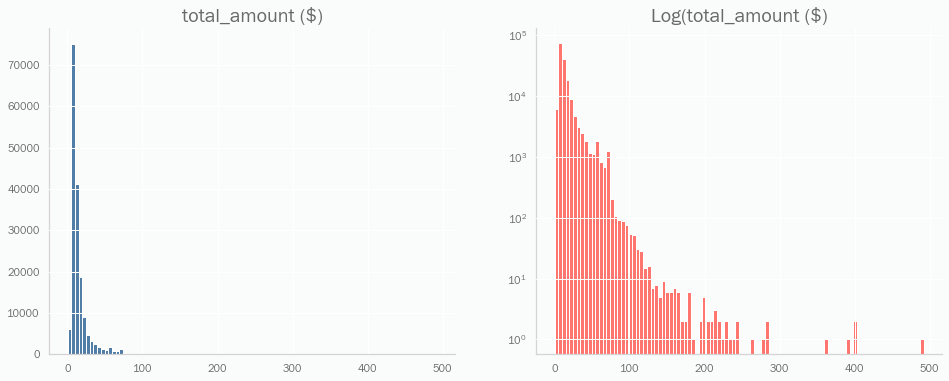

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

ax1 = (df["total_amount"]).hist(bins=100, ax =axes[0], color = color_palette[4])
ax2 = (df["total_amount"]).hist(bins=100, ax =axes[1], color = color_palette[1], log=True)

ax1.set_title("total_amount ($)")
ax2.set_title("Log(total_amount ($)")

plt.show()

**Tips**

As it can be observed in the figures below, tips also seem to follow an exponential distribution even more exagerated than the distribution of the total amount of money.

From this distribuition we can build the hypothesys that most of tips are very similar and not very high, but there are also some passengers giving veru high trips compared to the mean.

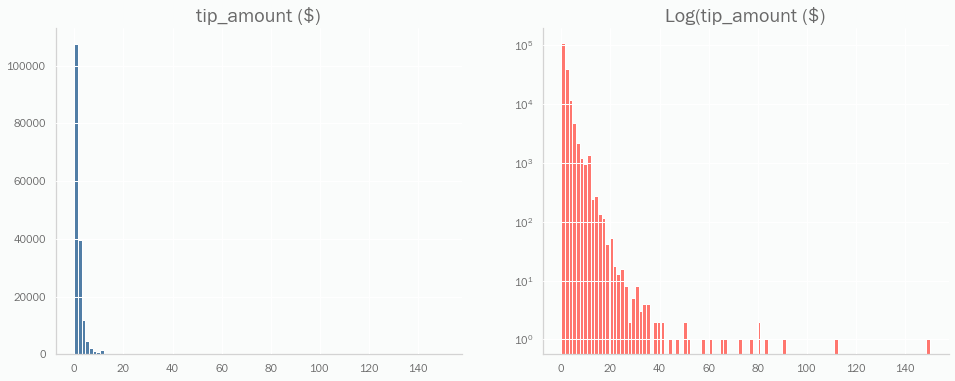

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

ax1 = (df["tip_amount"]).hist(bins=100, ax =axes[0], color = color_palette[4])
ax2 = (df["tip_amount"]).hist(bins=100, ax =axes[1], color = color_palette[1], log=True)

ax1.set_title("tip_amount ($)")
ax2.set_title("Log(tip_amount ($)")

plt.show()

### Correlation matrix

The next step is to know which variables are highly correlated. This is a very useful method to focus the analysis in some variables and to exclude redundant variables from the analysis and model.

We will exclude from the correlation matrix some variables we are not interested on: ***extra*** and ***mta_tax***.

We can observe some obvious correlations. For instance, the ***pickup_hour*** is highly correlated to the ***dropoff_hour*** as it was expected. All the hypothesis that we had about correlations among ***trip_duration***, ***trip_distance*** and ***total_amount*** are confirmed as well.

But there are some interesting correlations as well:
* The distance is positively correlated with the ***trip_speed***, which implies that higher distances often lead to higher speed which seems understandable as longer trips are more likely to involve highways.
<br><br>
* The same happens with ***trip_duration*** and ***trip_speed***. In this case the correlation is lower, maybe because sometimes higher durations imply traffic jams and therefore lower speed.
<br><br>
* ***Trip_speed*** is correlated to ***total_amount*** but probably because their common connection with ***trip_distance***.
<br><br>
* Another interesting correlation es the ***tip*** w.r.t ***distance*** and ***speed***, higher distances and speeds often imply higher tips for the taxi driver.
<br><br>
* There is an interesting negative correlation between ***tip_amount*** and ***payment_type***. Since ***payment_type*** is categorical but was coded as a number it was included in the corr matrix. We can examine this relation later on.

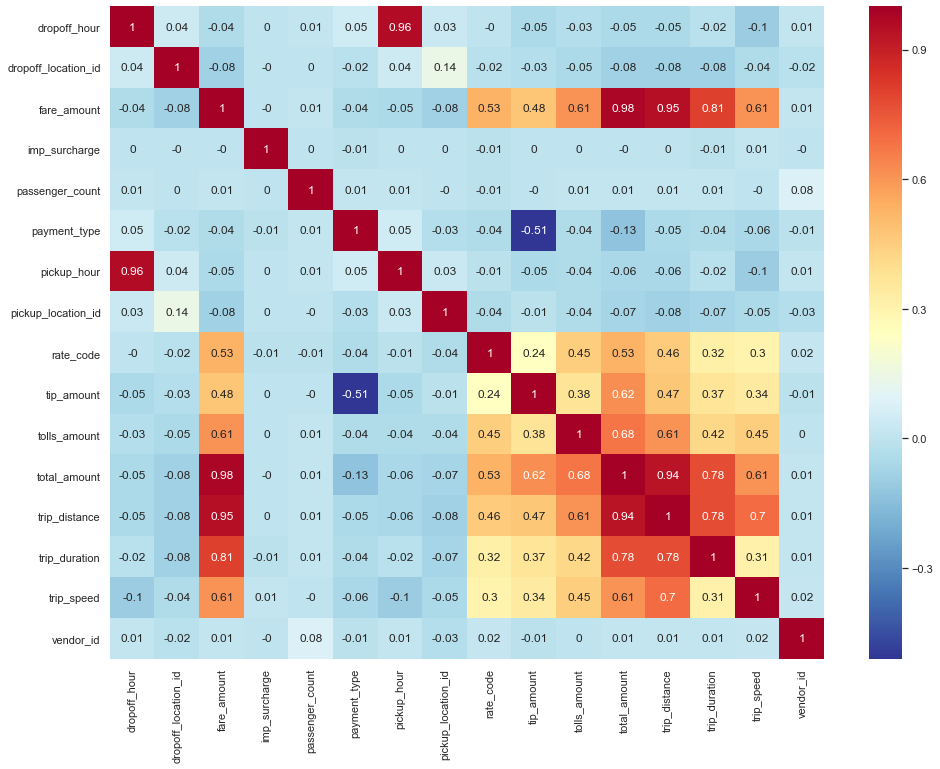

In [55]:
sns.set(rc={'figure.figsize':(16,12)})
sns.heatmap(round(df[df.columns.difference(['extra', 'mta_tax'])].corr(), 2), cmap="RdYlBu_r", annot=True)
plt.show()

### Multivariate analysis: Relations among multiple variables

#### Time of day and type of payment

The two main types of payment are credit card (payment_type = 1) and cash (payment_type = 2).

We can see that it is more common to pay with card during morning, on the other hand it is more likely that clients pay with cash during evening. During mornings there is probably much more people taking taxis to office and during evening more yougsters that are more likely to pay with cash.

It is also remarkable that there is a higher rate of taxi trips lablled as "No Charge" or "Dispute" during night. The NY city council should investigate if taxi drivers have more problems charging clients during late night. 

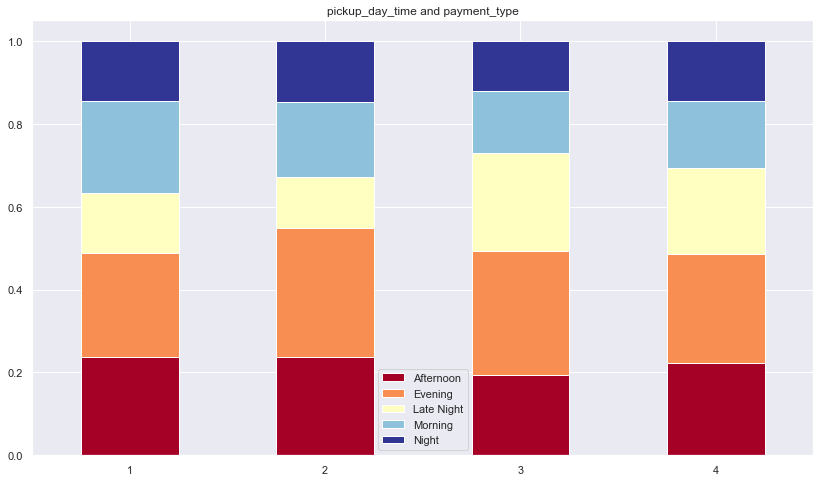

In [56]:
d = dict(df.groupby(['pickup_day_time', 'payment_type']).size())

sub_df1 = pd.DataFrame(d.values(), columns=['count'], index=pd.MultiIndex.from_tuples(d.keys()))
sub_df2 = sub_df1.unstack()
sub_df2.columns = sub_df2.columns.droplevel()  # Drop `count` label.
sub_df2 = sub_df2.div(sub_df2.sum())
sub_df2.T.plot(kind='bar', stacked=True, rot=1, figsize=(14, 8), title="pickup_day_time and payment_type", cmap="RdYlBu")

plt.show()

#### Vendor_id and time of day

The different vendors are more or less equally distributed for the different times of the day:

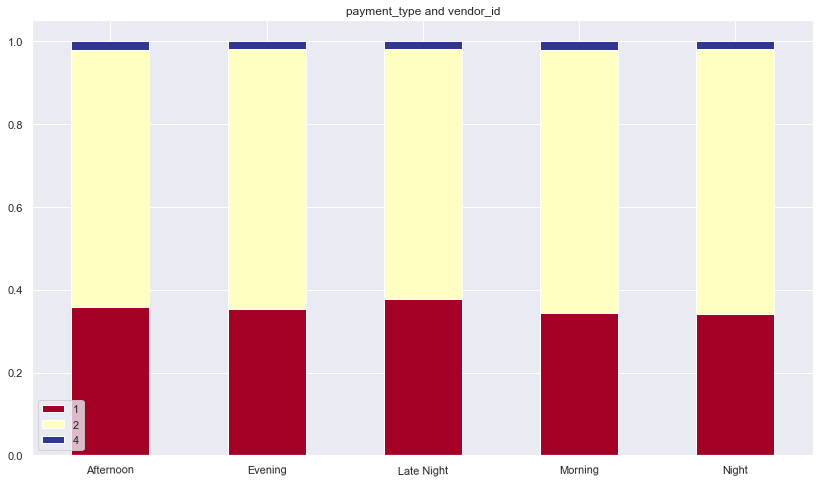

In [57]:
d = dict(df.groupby(['vendor_id', 'pickup_day_time']).size())

sub_df1 = pd.DataFrame(d.values(), columns=['count'], index=pd.MultiIndex.from_tuples(d.keys()))
sub_df2 = sub_df1.unstack()
sub_df2.columns = sub_df2.columns.droplevel()  # Drop `count` label.
sub_df2 = sub_df2.div(sub_df2.sum())
sub_df2.T.plot(kind='bar', stacked=True, rot=1, figsize=(14, 8), title="payment_type and vendor_id", cmap="RdYlBu")

plt.show()

#### Trip speed and time of day

We can see that taxi trips tend to have a higher speed during late night. That makes sense since during late night there is not much traffic and cars can drive faster. For the rest of the times the distribution is kind of similar, although trips seem to be a little slower during afternoon.

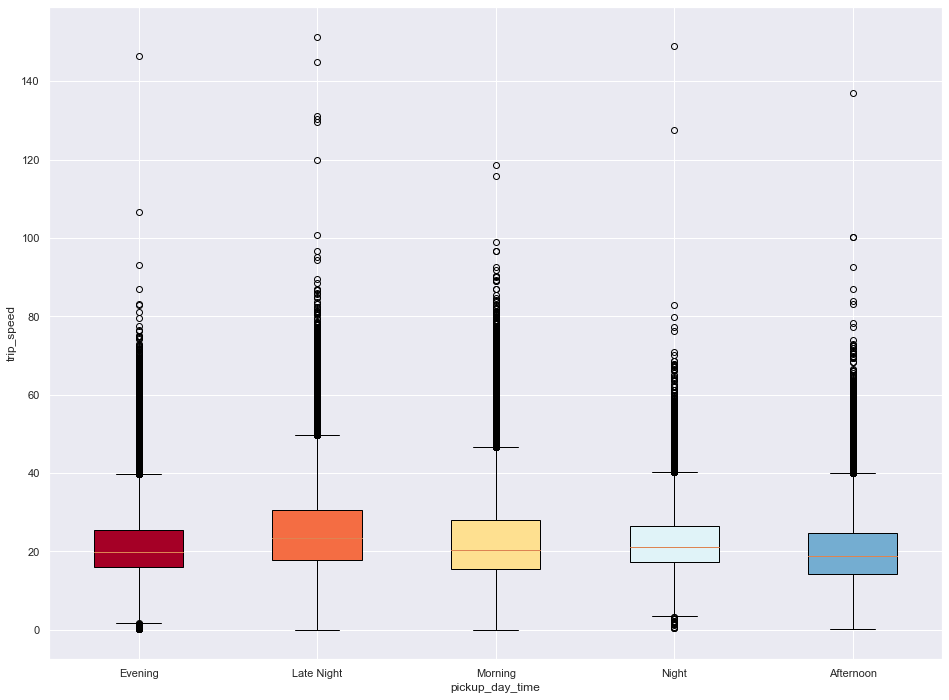

In [58]:
category = "pickup_day_time"
numerical = "trip_speed"

data = [df[df[category] == i][numerical] for i in df[category].unique()]
bplot = plt.boxplot(x=data, patch_artist=True, boxprops=dict(facecolor='black'))

cm = plt.cm.get_cmap('RdYlBu')
colors = [cm(val/len(df[category].unique())) for val in range(len(df[category].unique()))]

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ticks = [i + 1 for i, e in enumerate(df[category].unique())]
labels = [e for i, e in enumerate(df[category].unique())]
plt.xticks(ticks, labels)

plt.xlabel(category)
plt.ylabel(numerical)

plt.show()

#### Payment type and tip amount

It seems like most clients that are giving tips pay with credit card.

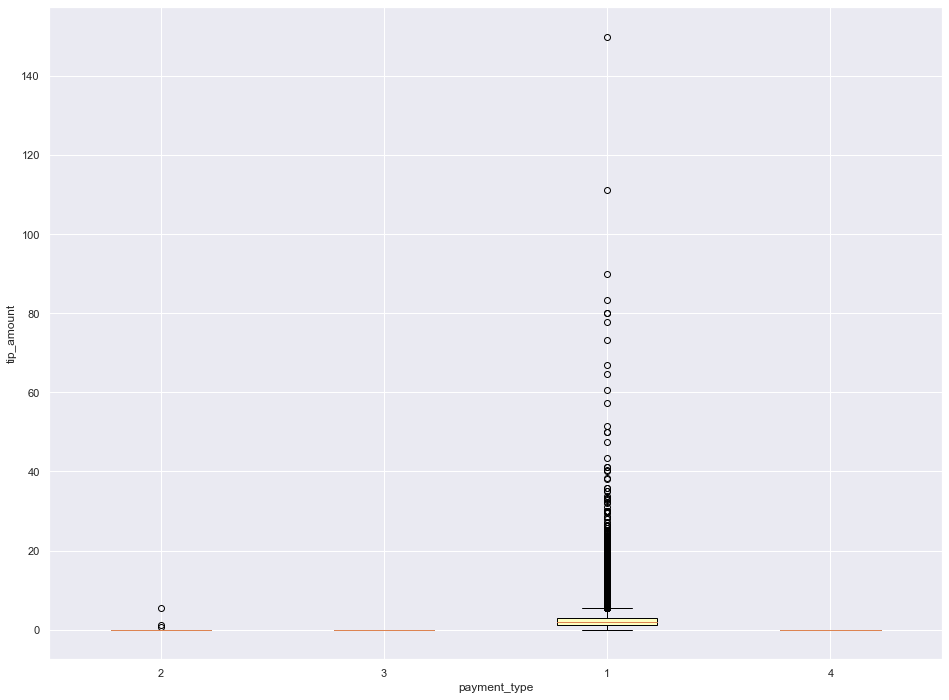

In [59]:
category = "payment_type"
numerical = "tip_amount"

data = [df[df[category] == i][numerical] for i in df[category].unique()]
bplot = plt.boxplot(x=data, patch_artist=True, boxprops=dict(facecolor='black'))

cm = plt.cm.get_cmap('RdYlBu')
colors = [cm(val/len(df[category].unique())) for val in range(len(df[category].unique()))]

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ticks = [i + 1 for i, e in enumerate(df[category].unique())]
labels = [e for i, e in enumerate(df[category].unique())]
plt.xticks(ticks, labels)

plt.xlabel(category)
plt.ylabel(numerical)

plt.show()

#### Distance and speed

Now to compare the relation between two numerical variables we aswitch to scatter plots.

We can observe that higher distances often impliy higher speeds. There is actually a threshold around 3-4 milles of ***trip-distance*** where the trend of ***trip_speed*** starts increasing. 

Probably from anywhere in NY city when you have to make a trip over 3-4 milles it implies to catch a road that allows to drive faster.

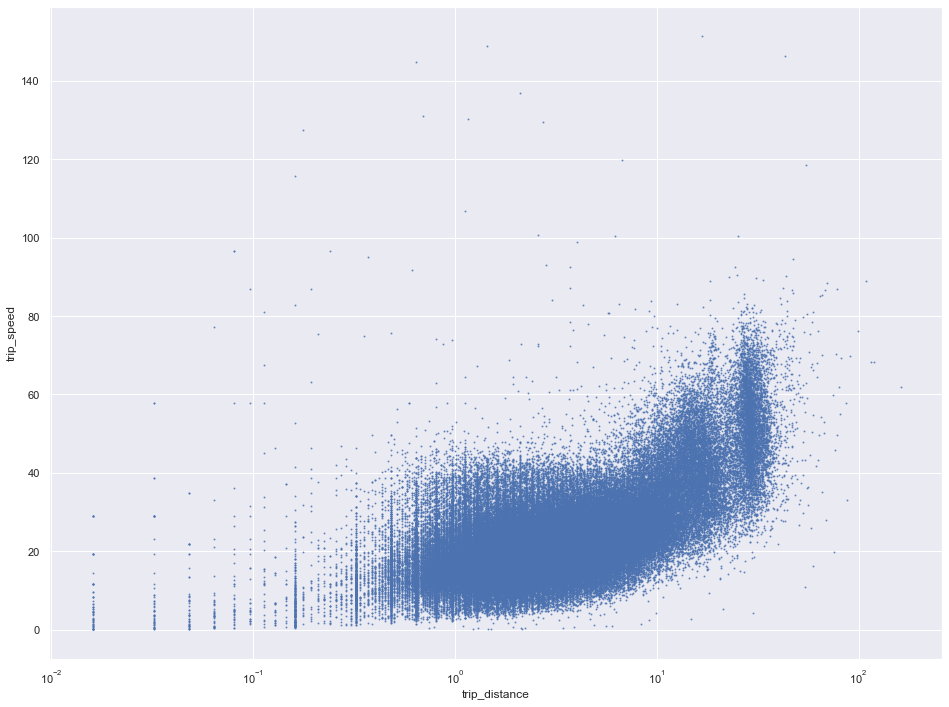

In [60]:
x = "trip_distance"
y = "trip_speed"

fig = plt.figure()
ax = plt.gca()

ax.scatter(x=df[x], y=df[y], s=1, alpha = 0.7)

ax.set_xscale('log')

plt.xlabel(x)
plt.ylabel(y)

plt.show()

#### Tips and speed

For these two variables there is a slight linear dependency indicating that some trips with higher speed often lead to bigger amounts tips. However. the pattern is not very clear so we will have to be careful with this relation and explore further dependencies.

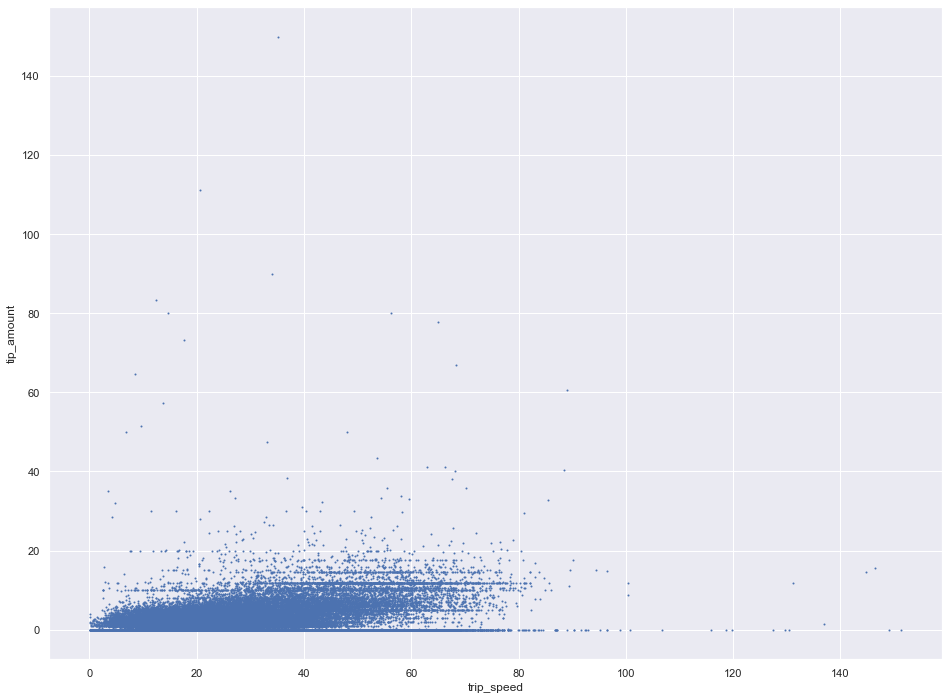

In [61]:
x = "trip_speed"
y = "tip_amount"

fig = plt.figure()
ax = plt.gca()

ax.scatter(x=df[x], y=df[y], s=1)

plt.xlabel(x)
plt.ylabel(y)

plt.show()

#### Distance, speed, and tips

We can also visualise three numerical features in a scatter plot by making the color or the size dependant to the third variable. In this way we can analyse the relation among ***trip_dsistance**, ***trip_speed*** and ***tips***.

In this chart we displayed the tip amount as the size of the circles and the color. It possible to observe that often larger tips are given in long trips with high speed.

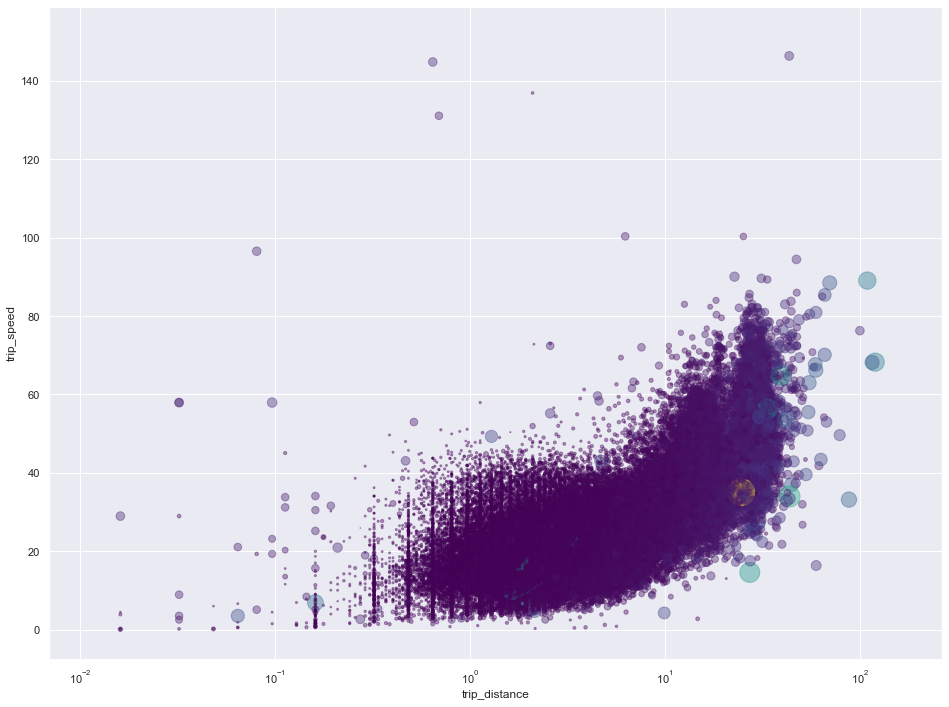

In [62]:
x = "trip_distance"
y = "trip_speed"
s = "tip_amount"

scaler = StandardScaler()

fig = plt.figure()
ax = plt.gca()

c = scaler.fit_transform(np.array(df[s]).reshape(len(df[s]), 1)).ravel()

ax.scatter(x=df[x], y=df[y], s=df[s]*5, c=c*10, alpha = 0.4, cmap="viridis")

ax.set_xscale('log')

plt.xlabel(x)
plt.ylabel(y)

plt.show()

#### Visualazing data on maps

In this data we have a geographical component, that are the pick-up and drop-off location ids. Whenever we have geo components in data it is interesting to visualise it on a map. By doing so we may be able to find patterns within data that otherwise would have been difficult to spot.

First we import the files containing the shapes of the taxi locations ids.

In [130]:
ny_geo = geopandas.read_file("taxi_zones.shp")

By examaning the geo dataframe we see that there are 263 Location IDs with their respective Boroughs, Zones and geo information.

In [131]:
ny_geo.tail(3)

OBJECTID  Shape_Leng  Shape_Area                zone  LocationID  \
260       261    0.027120    0.000034  World Trade Center         261   
261       262    0.049064    0.000122      Yorkville East         262   
262       263    0.037017    0.000066      Yorkville West         263   

       borough                                           geometry  
260  Manhattan  POLYGON ((980555.204 196138.486, 980570.792 19...  
261  Manhattan  MULTIPOLYGON (((999804.795 224498.527, 999824....  
262  Manhattan  POLYGON ((997493.323 220912.386, 997355.264 22...

Now we can see the NY areas plotted into a map.

In [132]:
ny_geo.crs

{'init': 'epsg:2263'}

Change crs so that shapes coordinates match with the coordinates of the basemap.

In [133]:
ny_geo_new = ny_geo.to_crs(epsg=3857)

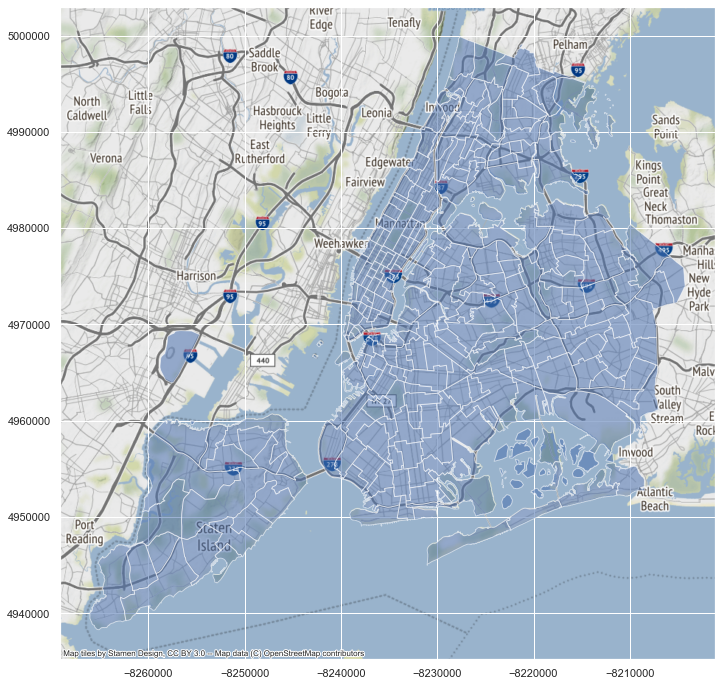

In [134]:
ax = ny_geo_new.plot(alpha=0.55)
cx.add_basemap(ax)

Let's JOIN the Geo Dataframe with the attributes dataframe so we can plot some info. We will aggregate some of the features by the location ids, such as count of trips, mean_distance, mean_speed, mean_duration, etc. 

In [135]:
df_agg_up = df.groupby(
    "pickup_location_id"
).agg(
    count=("trip_distance", "count"),
    mean_distance=("trip_distance", "mean"),
    median_distance=("trip_distance", "median"),
    max_distance=("trip_distance", "max"),
    mean_duration=("trip_duration", "mean"),
    median_duration=("trip_duration", "median"),
    max_duration=("trip_duration", "max"),
    mean_speed=("trip_speed", "mean"),
    median_speed=("trip_speed", "median"),
    max_speed=("trip_speed", "max"),
    mean_tip=("tip_amount", "mean"),
    median_tip=("tip_amount", "median"),
    max_tip=("tip_amount", "max"),
)

df_agg_off = df.groupby(
    "dropoff_location_id"
).agg(
    count=("trip_distance", "count"),
    mean_distance=("trip_distance", "mean"),
    median_distance=("trip_distance", "median"),
    max_distance=("trip_distance", "max"),
    mean_duration=("trip_duration", "mean"),
    median_duration=("trip_duration", "median"),
    max_duration=("trip_duration", "max"),
    mean_speed=("trip_speed", "mean"),
    median_speed=("trip_speed", "median"),
    max_speed=("trip_speed", "max"),
    mean_tip=("tip_amount", "mean"),
    median_tip=("tip_amount", "median"),
    max_tip=("tip_amount", "max"),
)

In [136]:
df_agg_up.reset_index(inplace=True)
df_agg_off.reset_index(inplace=True)

In [137]:
df_agg_up.head(3)

pickup_location_id  count  mean_distance  median_distance  max_distance  \
0                   1      1       0.096560         0.096560      0.096560   
1                   3      7       9.757199         4.747553     32.846629   
2                   4    418       5.599541         3.781949     30.625740   

   mean_duration  median_duration  max_duration  mean_speed  median_speed  \
0       6.000000              6.0           6.0   57.936240     57.936240   
1    1358.571429           1029.0        3486.0   22.168284     22.336864   
2     761.741627            642.0        3286.0   23.952267     20.855373   

   max_speed   mean_tip  median_tip  max_tip  
0  57.936240  18.160000       18.16    18.16  
1  37.742211   0.638571        0.00     4.47  
2  81.110736   1.295120        0.00    10.56

In [140]:
ny_geo_up_enriched = pd.merge(ny_geo, df_agg_up, how='left', left_on=['LocationID'], right_on=['pickup_location_id'])
ny_geo_off_enriched = pd.merge(ny_geo, df_agg_off, how='left', left_on=['LocationID'], right_on=['dropoff_location_id'])

ny_geo_up_enriched = ny_geo_up_enriched.to_crs(epsg=3857)
ny_geo_off_enriched = ny_geo_off_enriched.to_crs(epsg=3857)

**Where people take more taxi rides from (pick-up location)?**

In the map the red colors areas in the city where more taxi trips are taking place. These areas with a higher number of taxi trips are located within Manhattan. There is also an area, in the south of Queens where taxis are also taken with high frequency.

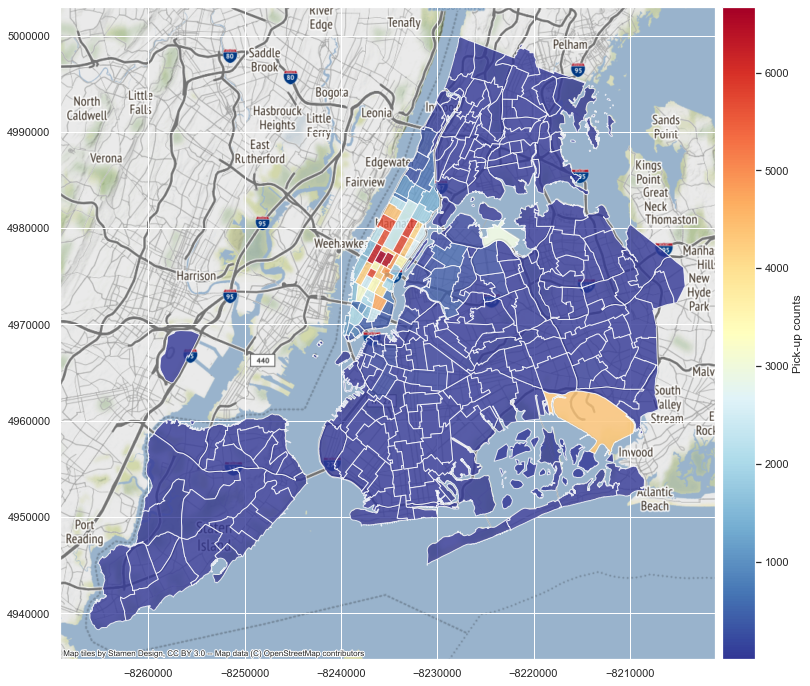

In [144]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = ny_geo_up_enriched.plot(column="count", ax=ax, legend=True, cmap="RdYlBu_r", alpha=0.75, cax=cax, legend_kwds={'label': "Pick-up counts"})
cx.add_basemap(ax)

**Let's now see where more taxi rides are finishing:**

The map looks very similar to where taxis are picked up. Probably most of the rides are within Manhattan.

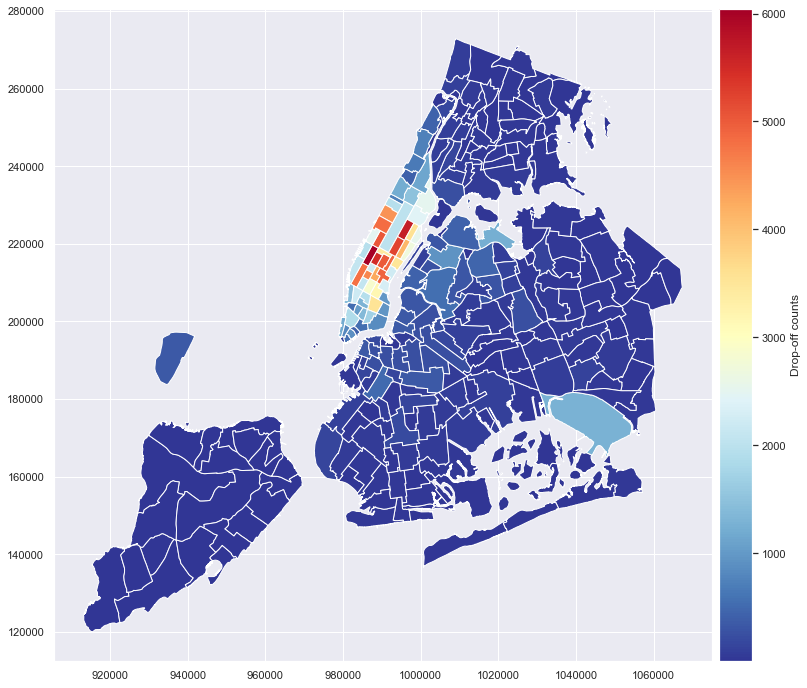

In [72]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = ny_geo_off_enriched.plot(column="count", ax=ax, legend=True, cmap="RdYlBu_r", alpha=0.75, cax=cax, legend_kwds={'label': "Drop-off counts"})
cx.add_basemap(ax)

**Where do long taxi trips end?**

As it was expected taxi rides with higher average distance finish in districts that are distant from Manhattan. Probably there is a flow of people going from Manhattan to residential areas, airport, etc, i.e., where the day life takes place to their homes. Blue colors in Manhattan show that distances of taxi trips finishing in this area are very low, as they are most likely moving within Manhattan.

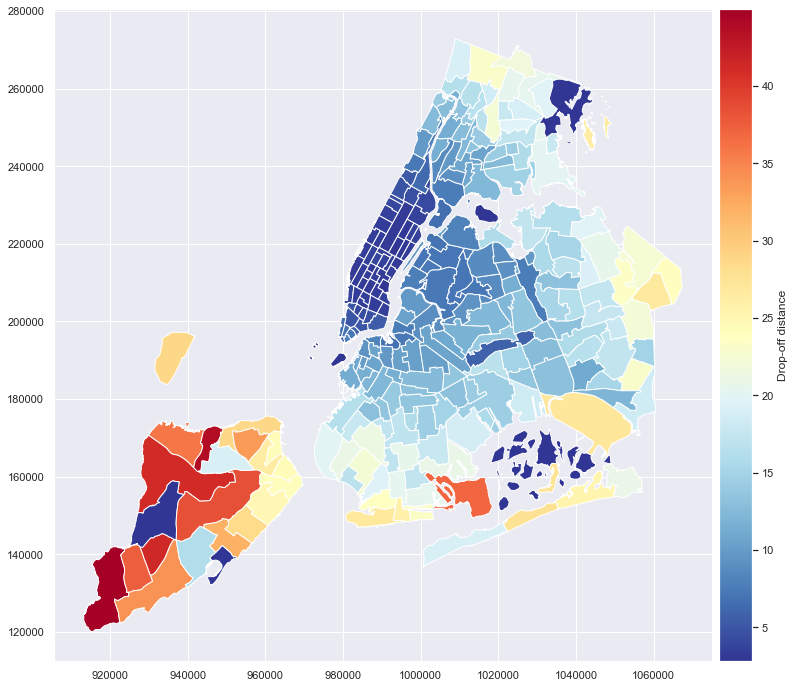

In [73]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = ny_geo_off_enriched.plot(column="mean_distance", ax=ax, legend=True, cmap="RdYlBu_r", alpha=0.75, cax=cax, legend_kwds={'label': "Drop-off distance"})
cx.add_basemap(ax)

If we plot the trip duration we expect to see a similar pattern in the map.

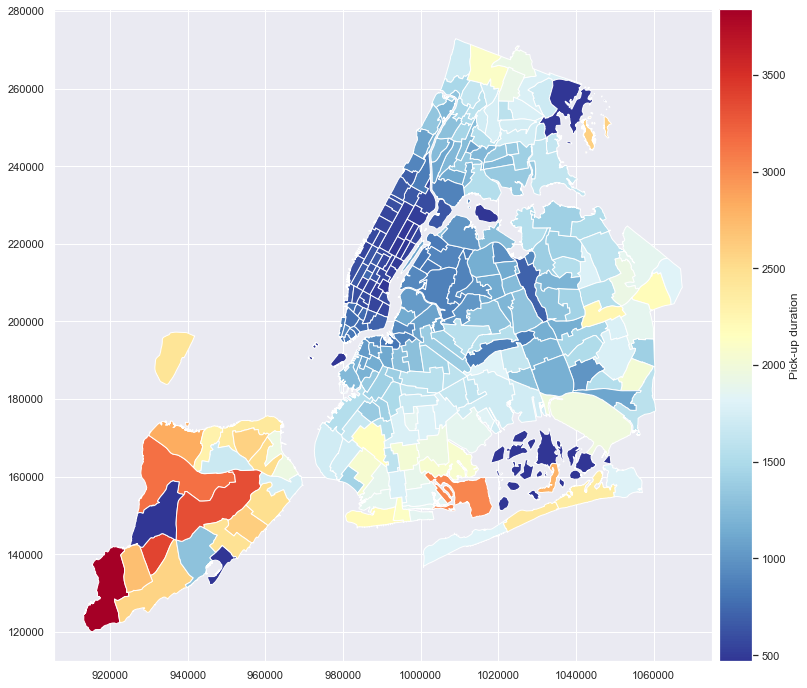

In [68]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = ny_geo_off_enriched.plot(column="mean_duration", ax=ax, legend=True, cmap="RdYlBu_r", alpha=0.75, cax=cax, legend_kwds={'label': "Pick-up duration"})
cx.add_basemap(ax)

**What about the speed? Where do taxi trips with a high average speed start?**

Areas in the outskirts of the city tend to have higher average trip speed. Besides the airport also tends to have taxi trips with an average high speed.

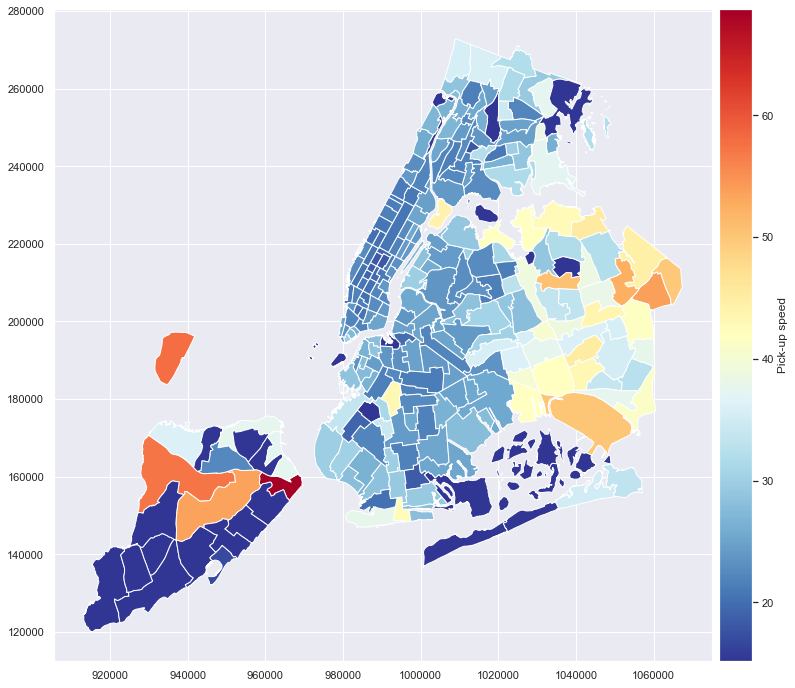

In [74]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = ny_geo_up_enriched.plot(column="mean_speed", ax=ax, legend=True, cmap="RdYlBu_r", alpha=0.75, cax=cax, legend_kwds={'label': "Pick-up speed"})
cx.add_basemap(ax)

**How do tips behave? Are there specific areas where the average tip is higher?**

It looks like certain areas in NY tend to have a higher tip. For instance, people in an area in the South of Queens and people being drop-off in some areas of Staten Island. Also people being drop-off at the Newark airport are giving much higher tips on average. On the other hand, trips that are ending in Manhattan and in the north-east of the city are having lower tips. 

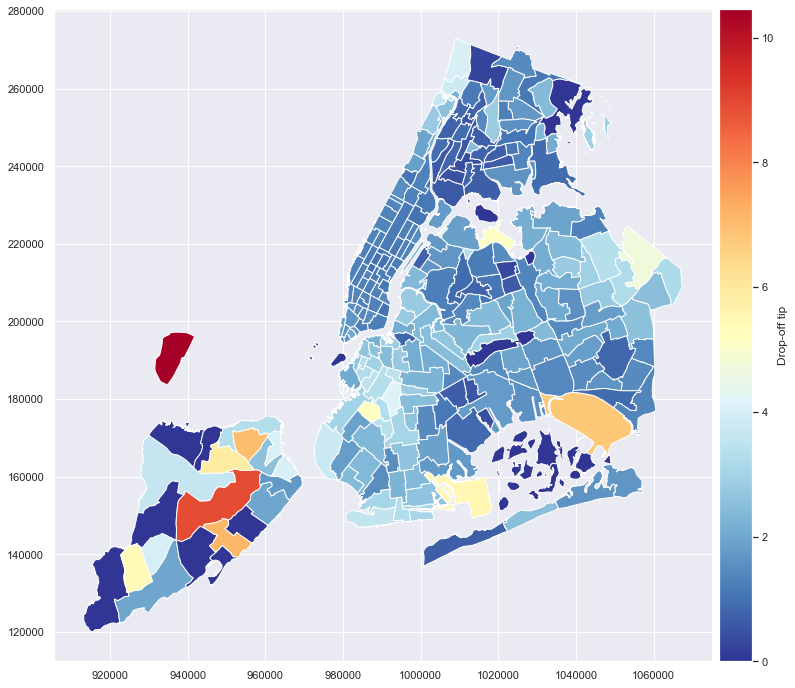

In [75]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = ny_geo_off_enriched.plot(column="mean_tip", ax=ax, legend=True, cmap="RdYlBu_r", alpha=0.75, cax=cax, legend_kwds={'label': "Drop-off tip"})
cx.add_basemap(ax)

On the other hand it looks like just people picking-up taxis at the airport are giving higher tips.

So the insight would be that just people going or comming from the airport is giving higher tips on average. Besides, depending on your destination from the airport, the tip may be higher for some areas than others.

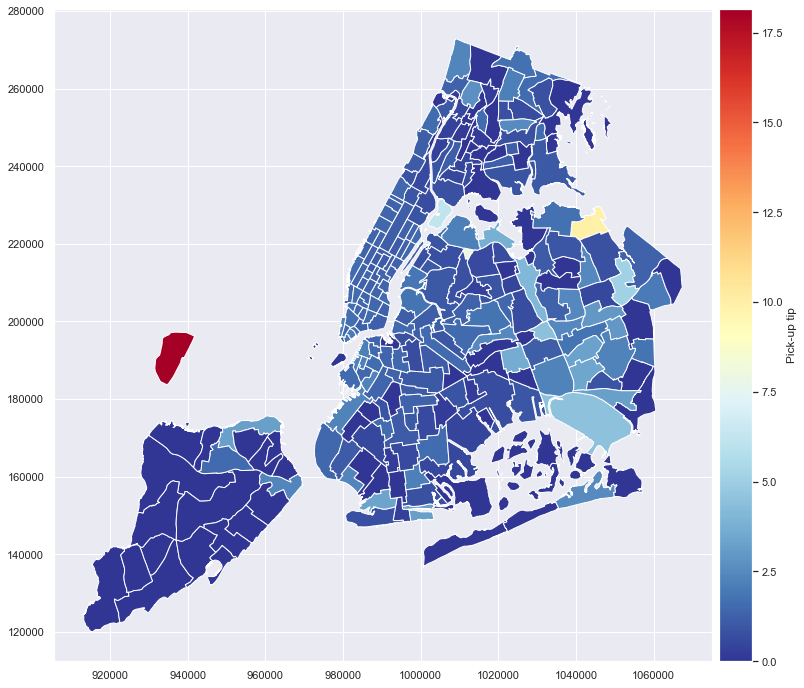

In [76]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = ny_geo_up_enriched.plot(column="mean_tip", ax=ax, legend=True, cmap="RdYlBu_r", alpha=0.75, cax=cax, legend_kwds={'label': "Pick-up tip"})
cx.add_basemap(ax)

## 3. Model Building

In this section the purpose is try to understand how tips behave by using a machine learning model. The process will involve training a model to predict trips based on the available samples and variables. Finally, we will attempt to extract some insights and understand which are the variables that influence the tips the most.

### Selecting features and Target

Now it is time to select the features that we are going to use to train the model to predict tips. Based on the knowledge we acquired with previous analysis we can make a good selection of model features. 

We avoid including redundant features such as fare_amount, total_amount... and we will include only one of them. We will include all variables related to trip information, such as distance, duration, speed. Besides, we will include vendor_id.

* **Target:** tip_amount
* **Features:** payment_type, rate_code, total_amount, trip_distance, trip_duration, trip_speed, vendor_id and pickup_day_time

There is too much location_ids to one-hot encode them. As we have another features such as trip_duration and time wo which we can link the location we will not include it in the model.

In [78]:
df["dropoff_location_id"].nunique()

257

In [79]:
target = "tip_amount"
numerical_features = ["total_amount", "trip_distance", "trip_duration", "trip_speed"]
categorical_features = ["payment_type", "rate_code", "vendor_id", "pickup_day_time"]

### One-hot encoding caterogical features

Machine learning models cannot cope with categories. At the end of the day a ML learning model is based on statistical models that operate with numbers. Hence, we need to convert categories into numerical vectors. To do so, we transform categories to one-hot encoded vectors. 

For instance, a category with 3 values: A, B and C can be one-hot encoded as A = 100, B = 010, C = 001.

In [80]:
encoder = OneHotEncoder()
categorical_feat_encoded = encoder.fit_transform(np.array(df[categorical_features])).toarray()

Before one-hot encoding

In [81]:
df[["payment_type", "rate_code", "vendor_id", "pickup_day_time"]][:1]

payment_type  rate_code  vendor_id pickup_day_time
0             2          5          1         Evening

After one-hot encoding.

In [82]:
categorical_feat_encoded[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.])

 The result should be 17 columns in the array.

In [83]:
df["payment_type"].nunique() + df["rate_code"].nunique() + df["vendor_id"].nunique() + df["pickup_day_time"].nunique()

17

In [84]:
categorical_feat_encoded.shape

(170194, 17)

### Scaling data: Normalization and Standardization (Z-scores)

Often Machine Learning models and even more regression models rely on calculating distances. Therefore, when we have data with very different distributions and magnitudes it can affect badly the performance of the model.

We can solve that with two approaches, normalization and standardization. Normalization scales everything in the [0, 1] interval, meanwhile Standardization scales everythin to fit a distribution of mean 0 and std=1 and copes better with outliers. For this later reason we have choosen Standardization to scale our data.

In [85]:
scaler = StandardScaler()

numerical_feat_standard = scaler.fit_transform(np.array(df[numerical_features]))

We check that indeed the distribution of the variables has changed to mean 0 and standard deviation 1.

Before:

In [91]:
print(np.array(df[numerical_features])[:, 1].mean())
print(np.array(df[numerical_features])[:, 1].std())

4.890308665298424
6.293063008742383


After:

In [86]:
print(numerical_feat_standard[:, 1].mean())
print(numerical_feat_standard[:, 1].std())

-2.498259474945321e-16
0.9999999999999999


#### Now we just concatenate bot numerical and categorical feature arrays.

In [92]:
X = np.concatenate((numerical_feat_standard,categorical_feat_encoded),axis=1)
Y = np.array(df["tip_amount"]).reshape(len(df["tip_amount"]), 1)

In [93]:
X.shape

(170194, 21)

In [94]:
Y.shape

(170194, 1)

### Train and test sets

Now we will divide the dataset into training and test sets. The training set will be used to train the model to learn structures in data to predict tips amount. The test set will be used to evaluate the performance of the model built on unseen data. In that way we will be able to check that the model is able to generalise.

* Train: We will use 80% of samples to train.
* Test: We will use 20% of samples to test.

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
y_train = y_train.ravel()
y_test = y_test.ravel()
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(136155, 21)
(34039, 21)
(136155,)
(34039,)


### Model selection

We will select a set of different regression models to compare performance among them.

In [96]:
models = {
    "RandomForest": RandomForestRegressor(),
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "KNeighborsRegressor": KNeighborsRegressor()
}

We validate the performance of our models using k-fold cross validation with a k = 5. We will use as performance errors:
* neg_mean_squared_error
* neg_median_absolute_error
* neg_mean_absolute_error
* r2

k-fold cross validation consists in dividing the dataset into k parts training k times the data on the k-1 parts and evaluating in the other part. The performance of the model is calculated as the mean of the metrics for each of the folds.

In [97]:
performance = dict()

for name, model in tqdm(models.items()):
    performance[name] = cross_validate(model, X_train, y_train, cv=5, scoring=('r2', 'neg_mean_squared_error', 'neg_median_absolute_error', 'neg_mean_absolute_error'))

Finally we print the performance metrics in terms of error for each model. The resulting errors are obtained by calculating the mean for the errors obtained for each fold of the cross validation.

We can observe the different metrics for the models we trained. Even if we see the word "test" followed by the error in the results, this would be the validation score. We will analyse test errors afterwards with the test dataset.

In [95]:
for model, errors in performance.items():
    print(model + "\n")
    for error, values in errors.items():
        if error in ['test_neg_mean_squared_error', 'test_neg_median_absolute_error', 'test_neg_mean_absolute_error']:
            print("\t" + error + ":\t" + str(round(np.mean(values),2)) + " (mean)\t" + str(round(np.std(values),2)) + "(std)")
        elif error in ["test_r2"]:
            print("\t" + error + ":\t\t\t " + str(round(np.mean(values),2)) + " (mean)\t" + str(round(np.std(values),2)) + "(std)")
    print("\n")

RandomForest

	test_r2:			 0.87 (mean)	0.02(std)
	test_neg_mean_squared_error:	-0.71 (mean)	0.17(std)
	test_neg_median_absolute_error:	-0.0 (mean)	0.0(std)
	test_neg_mean_absolute_error:	-0.15 (mean)	0.0(std)


LinearRegression

	test_r2:			 0.66 (mean)	0.01(std)
	test_neg_mean_squared_error:	-1.8 (mean)	0.14(std)
	test_neg_median_absolute_error:	-0.39 (mean)	0.0(std)
	test_neg_mean_absolute_error:	-0.67 (mean)	0.01(std)


Lasso

	test_r2:			 0.19 (mean)	0.01(std)
	test_neg_mean_squared_error:	-4.33 (mean)	0.36(std)
	test_neg_median_absolute_error:	-1.19 (mean)	0.01(std)
	test_neg_mean_absolute_error:	-1.34 (mean)	0.01(std)


Ridge

	test_r2:			 0.66 (mean)	0.01(std)
	test_neg_mean_squared_error:	-1.8 (mean)	0.14(std)
	test_neg_median_absolute_error:	-0.39 (mean)	0.0(std)
	test_neg_mean_absolute_error:	-0.67 (mean)	0.01(std)


KNeighborsRegressor

	test_r2:			 0.79 (mean)	0.03(std)
	test_neg_mean_squared_error:	-1.14 (mean)	0.25(std)
	test_neg_median_absolute_error:	-0.05 (mean)	0.0(st

Let's now execute our models on the test set.

In [98]:
performance_test = dict()

for name, model in tqdm(models.items()):
    md = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    performance_test[name] = {
        'r2_score': round(r2_score(y_test, y_pred), 2),
        'mean_squared_error' :round(mean_squared_error(y_test, y_pred), 2),
        'median_absolute_error': round(median_absolute_error(y_test, y_pred), 2),
        'mean_absolute_error': round(mean_absolute_error(y_test, y_pred), 2)}

We can see that RandomForest and KNeighboursRegressor provide the best results for MSE and MAE but the performance is worse R2. On the other hand, Lasso seems to be the model performing the best for the R2 score. We do not observe any strong overfiting.

In [99]:
for model, performance in performance_test.items():
    print(model)
    for error, value in performance.items():
        if error in ['mean_squared_error', 'median_absolute_error', 'mean_absolute_error']:
            print("\t" + error + ": \t" + str(value) + " (mean)\t")
        elif error in ["r2_score"]:
            print("\t" + error + ":\t\t " + str(value) + " (mean)\t")
    print("\n")

RandomForest
	r2_score:		 0.82 (mean)	
	mean_squared_error: 	1.13 (mean)	
	median_absolute_error: 	0.0 (mean)	
	mean_absolute_error: 	0.15 (mean)	


LinearRegression
	r2_score:		 0.63 (mean)	
	mean_squared_error: 	2.33 (mean)	
	median_absolute_error: 	0.39 (mean)	
	mean_absolute_error: 	0.68 (mean)	


Lasso
	r2_score:		 0.18 (mean)	
	mean_squared_error: 	5.12 (mean)	
	median_absolute_error: 	1.19 (mean)	
	mean_absolute_error: 	1.35 (mean)	


Ridge
	r2_score:		 0.63 (mean)	
	mean_squared_error: 	2.33 (mean)	
	median_absolute_error: 	0.39 (mean)	
	mean_absolute_error: 	0.68 (mean)	


KNeighborsRegressor
	r2_score:		 0.75 (mean)	
	mean_squared_error: 	1.54 (mean)	
	median_absolute_error: 	0.04 (mean)	
	mean_absolute_error: 	0.31 (mean)	




In [98]:
df["tip_amount"].mean()

1.4486523026661107

By looking at the average value of tips (1.448), we can see that some models are able to perform ok taking into account that we have not tuned any hyper parameter or tried any more powerful model such as Neural Netowrks or Catboost Regressor. The performance could be improved, but for the scope of the project the results are satisfactory.

The hypothesis is that given the exponential distribution of tips, it is most likely that models learnt to predict values around the mean and median of the distribution, but maybe are less effective when predicting values on the right tail of the distribution (higher tips).

### What factors influence the tip the most?

In order to calculate what factors affect the tip the most we have can use the feature importance that the RandomForestRegressor provides.

If we recall the variables that we used to train the model and in which order we included them:

In [105]:
numerical_features = ["total_amount", "trip_distance", "trip_duration", "trip_speed"]
categorical_features = ["payment_type", "rate_code", "vendor_id", "pickup_day_time"]

The most important variables were ***total_amount***, ***payment_type***, ***trip_distance**...

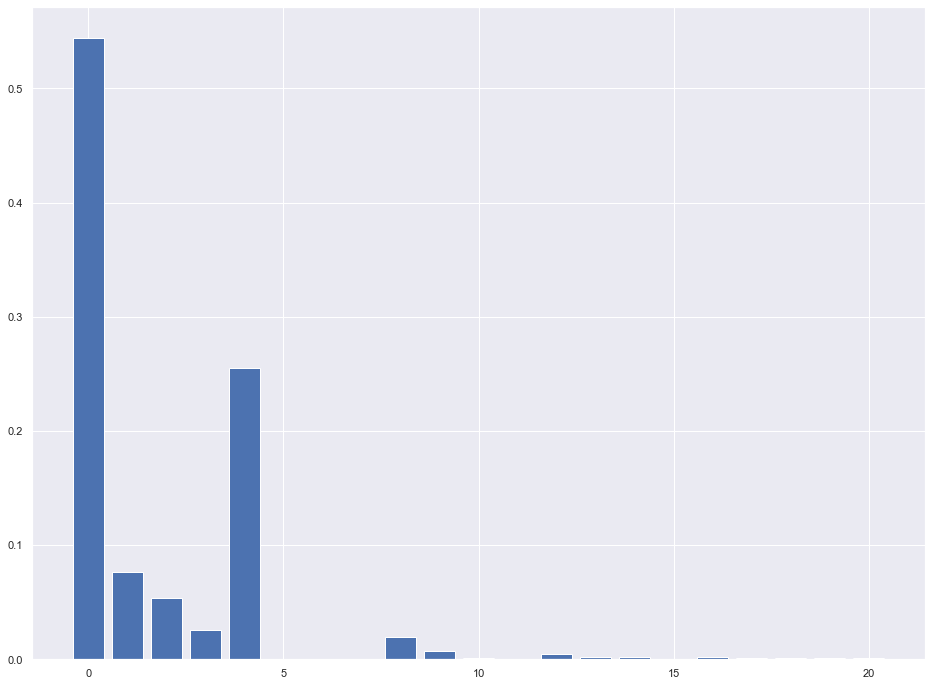

In [104]:
importance = models["RandomForest"].feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()